# The effects of "interlaced" painting

In this notebook, we'll outline the effects of using so-called interlacing when painting a density field to a mesh. Interlacing is designed to reduce the effects of aliasing, which is caused by the finite sampling of the mesh. Aliasing leads to spurious contributions to Fourier space statistics, and the effects become worse as one approaches the Nyquist frequency, defined as:

$$
k_\mathrm{nyq} = \pi \frac{N_\mathrm{mesh}}{L_\mathrm{box}}
$$

Interlacing is designed to remove the odd high-frequency image multiples, thus reducing the overall aliasing contribution at $k < k_\mathrm{nyq}$.

Here, we will consider the effects on interlacing on the power spectrum when using a mesh of size $N_\mathrm{mesh}=256$, as compared to the "truth", computed using a mesh with 2x resoluton, i.e., $N_\mathrm{mesh} = 512$. We also consider the effects when using the CIC and TSC paintbrushes. 

As the goal of this notebook is to show the reduction in aliasing due to the interlacing technique, we will only correct the power spectrum for the effect of the paintbrush window, without including any additional corrections for the aliasing contribution. This amounts to dividing the power spectrum by:

$$
W^2(k_x, k_y, k_z) = \Pi_i^{x,y,z} \left [ \frac{\sin[\pi k_i / (2 k_\mathrm{nyq})]}{ \pi k_i / (2 k_\mathrm{nyq})} \right ]^p,
$$
where $p = 4,6$ for CIC and TSC painters, respectively.

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

from nbodykit import algorithms, painters, transfers, datasources
from nbodykit.cosmology import Cosmology
from nbodykit.dataset import Power1dDataSet

For this test, we'll compare the power spectrum computed using the `FFTPower` Algorithm and the `ZeldovichSim` DataSource (to produce realistic results) with and without interlacing.

In [9]:
# the parameters for FFTPower
mode = '1d'
cosmo = Cosmology(Om0=0.31, flat=True)

# initialize the ZeldovichSim
data = datasources.ZeldovichSim(nbar=3e-5, redshift=0., BoxSize=512, Nmesh=256, seed=42, cosmo=cosmo)

In [51]:
def compute_power_spectrum(paintbrush, Nmesh, interlaced=False):
    """
    Given a paintbrush and mesh size, return a Power1dDataSet
    holding the power spectrum result
    """
    chain = [transfers.NormalizeDC(), transfers.RemoveDC()]
    
    # determine the chain and paintbrush
    if not interlaced:
        painter = painters.DefaultPainter(interlaced=False, paintbrush=paintbrush)
    else:
        painter = painters.DefaultPainter(interlaced=True, paintbrush=paintbrush)
        
    if paintbrush == 'tsc':
        chain += [transfers.TSCWindow()]
    elif paintbrush == 'cic':
        chain += [transfers.CICWindow()] 

            
    # intialize the algorithm
    field = [data, painter, chain]
    alg = algorithms.FFTPower(mode=mode, field=field, Nmesh=Nmesh, paintbrush=paintbrush)
    
    # run the algorithm
    edges, result, _, meta = alg.run()
    
    # format the output
    edges = edges[0]
    cols = ['k', 'power', 'modes']
    result = [np.squeeze(result[i]) for i in [0, 2, 3]]
    dset = Power1dDataSet(edges, dict(zip(cols, result)), **meta)
    
    return dset 

In [56]:
# consider the "truth" as TSC on hi-resolution (2x) mesh
truth = compute_power_spectrum(paintbrush='tsc', Nmesh=512, interlaced=False)

In [58]:
# interlaced, half mesh
tsc_int = compute_power_spectrum(paintbrush='tsc', Nmesh=256, interlaced=True)
cic_int = compute_power_spectrum(paintbrush='cic', Nmesh=256, interlaced=True)

# non-interlaced, half mesh
tsc_noint = compute_power_spectrum(paintbrush='tsc', Nmesh=256, interlaced=False)
cic_noint = compute_power_spectrum(paintbrush='cic', Nmesh=256, interlaced=False)

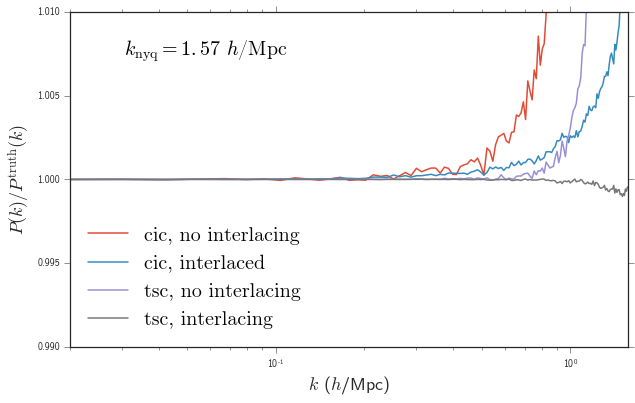

In [79]:
# plot the results

with plt.style.context(['ggplot', 'seaborn-ticks']):
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.gca()

    # normalize by the "truth"
    norm = InterpolatedUnivariateSpline(truth['k'], truth['power'].real)
    
    # cic results
    ax.plot(cic_noint['k'], cic_noint['power'].real / norm(cic_noint['k']), label='cic, no interlacing')
    ax.plot(cic_int['k'], cic_int['power'].real / norm(cic_int['k']), label='cic, interlaced')
    
    # tsc results
    ax.plot(tsc_noint['k'], tsc_noint['power'].real / norm(tsc_noint['k']), label='tsc, no interlacing')
    ax.plot(tsc_int['k'], tsc_int['power'].real / norm(tsc_int['k']), label='tsc, interlacing')


# the nyquist frequency
k_nyq = np.pi * 256. / 512.
plt.figtext(0.2, 0.8, r"$k_\mathrm{nyq} = %.2f$ $h$/Mpc" %k_nyq, fontsize=20)

# format the axes
ax.set_xscale('log')
ax.set_ylim(0.99, 1.01)
ax.set_xlim(0.02, k_nyq)
ax.legend(loc=0, fontsize=20)
ax.set_xlabel(r"$k$ ($h$/Mpc)", fontsize=18)
ax.set_ylabel(r"$P(k) / P^\mathrm{truth}(k)$", fontsize=18)
plt.show()